# Рекомендательная система кинофильмов 

___Набор данных movies.csv:___  
Набор данных состоит из 979 записей о кинофильмах.

- `title` - название кинофильма;
- `star_rating` - рейтинг фильма;
- `content_rating` - рейтинг MPAA(Motion Picture Association of America);
- `genre` - жанр кинофильма;
- `duration` - продолжительность фильма в минутах;
- `actors_list` - список актеров кинофильма.
***

# 1. Загружаем набор данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors


movies = pd.read_csv('movies.csv')

Посмотрим на первые 5 строк:

In [2]:
movies.head()

,star_rating,title,content_rating,genre,duration,actors_list
0,9.3,The Shawshank Redemption,R,Crime,142,"[u'Tim Robbins', u'Morgan Freeman', u'Bob Gunt..."
1,9.2,The Godfather,R,Crime,175,"[u'Marlon Brando', u'Al Pacino', u'James Caan']"
2,9.1,The Godfather: Part II,R,Crime,200,"[u'Al Pacino', u'Robert De Niro', u'Robert Duv..."
3,9.0,The Dark Knight,PG-13,Action,152,"[u'Christian Bale', u'Heath Ledger', u'Aaron E..."
4,8.9,Pulp Fiction,R,Crime,154,"[u'John Travolta', u'Uma Thurman', u'Samuel L...."


In [3]:
movies.shape

(979, 6)

In [4]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 979 entries, 0 to 978
Data columns (total 6 columns):
star_rating       979 non-null float64
title             979 non-null object
content_rating    976 non-null object
genre             979 non-null object
duration          979 non-null int64
actors_list       979 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 46.0+ KB


***
# 2. Подготовка данных и борьба с пропусками

Посмотрим на количество пропусков:

In [5]:
movies.isnull().sum()

star_rating       0
title             0
content_rating    3
genre             0
duration          0
actors_list       0
dtype: int64

In [6]:
movies[movies['content_rating'].isnull()].head()

,star_rating,title,content_rating,genre,duration,actors_list
187,8.2,Butch Cassidy and the Sundance Kid,NaN,Biography,110,"[u'Paul Newman', u'Robert Redford', u'Katharin..."
649,7.7,Where Eagles Dare,NaN,Action,158,"[u'Richard Burton', u'Clint Eastwood', u'Mary ..."
936,7.4,True Grit,NaN,Adventure,128,"[u'John Wayne', u'Kim Darby', u'Glen Campbell']"


У некоторых кинофильмов отсутствует content_rating. Так как пропусков немного, можем заполнить их вручную.

In [7]:
known_movies = {
    "Butch Cassidy and the Sundance Kid": "PG",
    "Where Eagles Dare": "PG",
    "True Grit": "PG-13"
}

for k,v in known_movies.items():
    movies.loc[movies["title"] == k, "content_rating"] = v

Если пропусков много, можем удалить из набора данных строки, в которых не указан content_rating.

In [8]:
# movies = movies[~movies['content_rating'].isnull()]

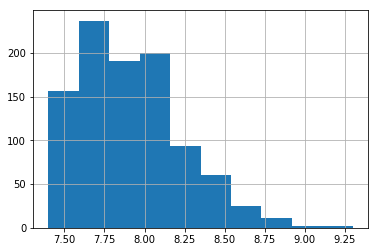

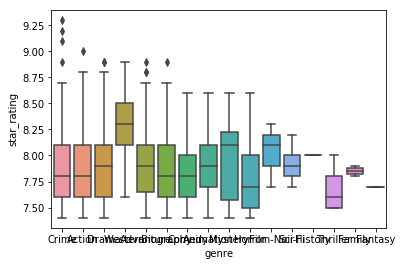

In [9]:
movies["star_rating"].hist()
plt.show()
sns.boxplot(data=movies, x='genre', y='star_rating')
plt.show()

Для признаков genre и content_rating произведем преобразование строк в числа.

In [10]:
movies_features = pd.concat([
    movies["genre"].str.get_dummies(sep=", "),
    movies[["star_rating"]],
    movies["content_rating"].str.get_dummies(sep=", "),
    movies["duration"]
], axis=1)
movies_features.head()

,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,...,NC-17,NOT RATED,PASSED,PG,PG-13,R,TV-MA,UNRATED,X,duration
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,142
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,175
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,200
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,152
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,154


In [11]:
movies_features.columns

Index(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror',
       'Mystery', 'Sci-Fi', 'Thriller', 'Western', 'star_rating', 'APPROVED',
       'G', 'GP', 'NC-17', 'NOT RATED', 'PASSED', 'PG', 'PG-13', 'R', 'TV-MA',
       'UNRATED', 'X', 'duration'],
      dtype='object')

In [12]:
print(movies["star_rating"].min(),'<= star_rating <=',movies["star_rating"].max())
print(movies["duration"].min(),'<= duration <=',movies["duration"].max())

7.4 <= star_rating <= 9.3
64 <= duration <= 242


  В нашем наборе данных рейтинг кинофильмов варьируется от 7.4 до 9.3, в то время как продолжительность кинофильмов(в минутах) варьируется от 64 до 242.
Для масштабирования значений рейтинга от 0 до 1 используем **sklearn.preprocessing.MinMaxScaler**.

In [13]:
min_max_scaler = MinMaxScaler()
movies_features = min_max_scaler.fit_transform(movies_features)

np.round(movies_features, 2)

c:\users\orl\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.44],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.62],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.76],
       ...,
       [1.  , 0.  , 0.  , ..., 0.  , 0.  , 0.42],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.28],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.35]])

***
# 3. Метод К-ближайших соседей (K nearest Neighbor, KNN)
Для поиска похожих кинофильмов мы будем использовать очень простой алгоритм машинного обучения - метод K-ближайших соседей, суть которого заключается в поиске k наиболее похожих объектов на данный при заданной метрике схожести, которой может быть euclidean (Евклидово расстояние), jaccard similarity (коэффициент Жаккара) , minkowsky (метрика Минковского) или произвольная метрика.
KNN используется как в задачах классификации, так и в задачах регрессии. При решении задач классификации для прогнозирования метки класса мы сначала ищем ближайших объектов

In [14]:
# helper functions
def get_index_from_title(title):
    return movies[movies["title"]==title].index.tolist()[0]

def get_id_from_partial_title(partial):
    for title in all_movies_titles:
        if partial in title:
            print(title,all_movies_titles.index(title))

def print_similar_movies(query=None,id=None):
    if id:
        for id in indices[id][1:]:
            print(movies.iloc[id]["title"])
    if query:
        found_id = get_index_from_title(query)
        for id in indices[found_id][1:]:
            print(movies.iloc[id]["title"])

In [15]:
# Fit Nearest Neighbor To Data
nbrs = NearestNeighbors(n_neighbors=6, algorithm='ball_tree').fit(movies_features)
distances, indices = nbrs.kneighbors(movies_features)
all_movies_titles = list(movies.title.values)

In [16]:
# Query Examples
print_similar_movies("Star Wars")

Star Wars: Episode V - The Empire Strikes Back
Raiders of the Lost Ark
Star Wars: Episode VI - Return of the Jedi
The Adventures of Robin Hood
The Man Who Would Be King


In [17]:
[title for title in movies.title if title.startswith("The Lord of the Rings")]

['The Lord of the Rings: The Return of the King',
 'The Lord of the Rings: The Fellowship of the Ring',
 'The Lord of the Rings: The Two Towers']